<h1> Using MOMENT for Forecasting </h1>
<hr>

## Contents
### 1. A Quick Introduction to Forecasting
### 2. Loading MOMENT
### 3. Inputs and Outputs
### 4. Training the Forecasting Head

## 1. A Quick Introduction to Forecasting

Time series forecasting is another popular modeling task that involves predicting future values of a time series based on its historical patterns. For instance, in the context of stock market data, forecasting aims to estimate the future stock prices by analyzing past price movements and other relevant factors. In this tutorial, we will explore how to use MOMENT to tackle the time series forecasting in linearly probed setting. Mathematically, the time series forecasting problem can be defined as follows:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables), the forecasting problem is to predict the next $H$ time-steps $[x_{L+1}, \dots, x_{L+H}]$. Depending on the length of the horizon, forecasting can be categorized as short or long-horizon

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model.

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` and `imputation.ipynb` notebooks for more details!

In the `embedding model`, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `representation_learning.ipynb` notebook for more details!

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [1]:
# !pip install numpy pandas matplotlib tqdm
# !pip install git+https://github.com/moment-timeseries-foundation-model/moment.git
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
import sys
import os

# Add your project root to sys.path (adjust the path below)
project_root = '/work/pi_shenoy_umass_edu/hshastri/FMaaS-motivation/timeseries/moment-main'  # the folder containing 'momentfm'
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(f"{project_root}/tutorials")

In [3]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-small", 
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 192,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

In [4]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (

/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [5]:
print("Unfrozen parameters:")
for name, param in model.named_parameters():    
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


## 3. Inputs and Outputs

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs:

1. An input time series of length $T = 512$ timesteps and $C$ channels, and
2. Two optional masks, both of length $T = 512$.
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our paper). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a forecasting task, it returns a `forecast` of the input.

In [6]:
from pprint import pprint
import torch
model.to("cuda").float()
# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x.float().to('cuda'))
forecast=output.forecast
forecast= forecast.reshape(forecast.shape[0], -1)
print(forecast.shape)  # Should be [batchsize, n_channels, forecast_horizon]

/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


torch.Size([16, 192])


### 4.2 Unsupervised Representation Learning using MOMENT

In this setting, we use MOMENT to embed all training and testing time series. Then we train a statistical regressor (e.g. support vector machine) using the embeddings of the training time series as features and training labels. We will show that MOMENT can learn meaningful representations in a zero-shot setting, which can be used to train powerful statistical regressor. 

Let's embed the train and test datasets! We'll proceed as follows: 
First, we will write a simple function `get_embedding` which will iterate over the training and testing datasets, and embed each time series. Then we will use the `fit_svm` function to fit a support vector machine (SVM) model using these embeddings as features and training labels. 

In [ ]:
# train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
# train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)
# test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [ ]:
# for timeseries, forecast, input_mask in tqdm(train_dataloader, total=len(train_dataloader)):
#     print(timeseries.shape, forecast.shape, input_mask.shape)

  0%|                                                                                                                                                                                                                                              | 0/993 [00:00<?, ?it/s]

torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 993/993 [00:00<00:00, 6506.44it/s]

torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size([8, 7, 192]) torch.Size([8, 512])
torch.Size([8, 7, 512]) torch.Size

In [ ]:
# from tqdm import tqdm

# def get_embedding(model, dataloader):
#     embeddings, labels = [], []
#     with torch.no_grad():
#         for timeseries, forecast, input_mask in tqdm(train_dataloader, total=len(train_dataloader)):
#             # Move the data to the GPU
#             timeseries = timeseries.float().to('cuda')
#             input_mask = input_mask.to('cuda')
#             forecast = forecast.float().to('cuda')


#             output = model(x_enc=timeseries, input_mask=input_mask)
#             # print(output.forecast.shape())
#             # embedding = output.embeddings
#             forecast_result=output.forecast
#             forecast_result=forecast_result.reshape(forecast_result.shape[0], -1)  # Flatten the forecast result
#             forecast= forecast.reshape(forecast.shape[0], -1)
#             embeddings.append(forecast_result.detach().cpu().numpy())
#             labels.append(forecast.detach().cpu().numpy())        

#     embeddings, labels = np.concatenate(embeddings), np.concatenate(labels)
#     return embeddings, labels

In [ ]:
# model.to("cuda").float()

# train_embeddings, train_labels = get_embedding(model, train_dataloader)
# test_embeddings, test_labels = get_embedding(model, test_dataloader)


# print(train_embeddings.shape, train_labels.shape)
# print(test_embeddings.shape, test_labels.shape)

  0%|                                                                                                                                                                                                                                              | 0/993 [00:00<?, ?it/s]/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████████████████

(7937, 1344) (7937, 1344)
(7937, 1344) (7937, 1344)


In [ ]:
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.svm import LinearSVR
# svr = LinearSVR(max_iter=10000)
# multi_svr = MultiOutputRegressor(svr)
# multi_svr.fit(train_embeddings, train_labels)

/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

KeyboardInterrupt: 

In [ ]:
# y_pred_train = multi_svr.predict(train_embeddings)
# y_pred_test = multi_svr.predict(test_embeddings)
# from sklearn.metrics import mean_absolute_error

# mae = mean_absolute_error(test_labels, y_pred_test)
# print("MAE:", mae)

## 4. Training the Forecasting Head

MOMENT is pre-trained using a reconstruction head and a reconstruction head. To use MOMENT for forecasting, we replace the reconstruction head to a forecasting head. The forecasting head is a randomly initilized linear layer which maps MOMENT's embeddings to the forecasting horizon. 

**The forecasting head is randomly initialized, so it must be trained on your data.**

Below, we show a quick example of how we can train the forecasting head. In these experiments, we will use Hourly Electricity Transformer Temperature (ETTh1) dataset introduced by [Zhou et al., 2020](https://arxiv.org/abs/2012.07436). Check out [ETDataset](https://github.com/zhouhaoyi/ETDataset) for more information! This dataset is widely use to benchmark long-horizon forecasting models. 

In this experiment, MOMENT will take multi-variate time series as input, and predict the next 192 time steps, i.e. the forecast horizon is set to 192. We will fine-tune the model using Mean Squarred Error (MSE), and report both MSE and the Mean Absolute Error (MAE) of the fine-tuned model. Since MOMENT is already pre-trained on millions of time series, we only need to fine-tune it for 1 epoch!

We implemented a simple forecasting dataset class in `moment.data.informer_dataset`. `moment.utils.forecasting_metrics` contains implementations for MSE and MAE.

### 4.1 Model Finetuning

In [ ]:


# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 1

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)
        
        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1
    
    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)
            
            loss = criterion(output.forecast, forecast)                
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())
    
    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


/tmp/ipykernel_1090251/1686837204.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                                                                                                                                                                                                | 0/993 [00:00<?, ?it/s]/tmp/ipykernel_1090251/1686837204.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the 

Epoch 0: Train loss: 0.471


  0%|                                                                                                                                                                                                                                | 0/337 [00:00<?, ?it/s]/tmp/ipykernel_1090251/1686837204.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 337/337 [02:25<00:00,  2.32it/s]


Epoch 1: Test MSE: 0.420 | Test MAE: 0.431


### 4.2 Visualization

Next, let's visualize the forecasts for a sample from the ETTh1 dataset and compare it with the ground truth forecast for the given time series.

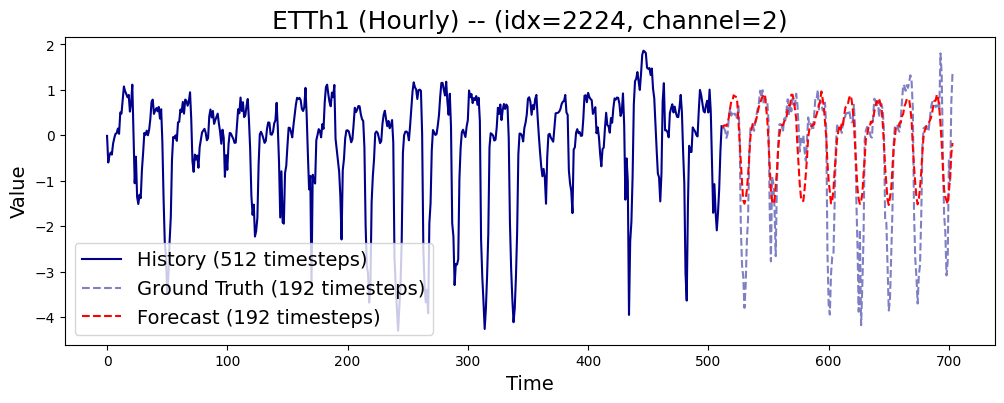

In [ ]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = np.random.randint(0, 7) # There are 7 channels in this dataset
time_index = np.random.randint(0, trues.shape[0]) 

history = histories[time_index, channel_idx, :] 
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (192 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (192 timesteps)', color='red', linestyle='--')

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### 4.3 Results Interpretation: MOMENT Performs Well for Forecasting in Limited Supervision Settings

Here, we can see that MOMENT **trained for 1 epoch only, without any hyperparameter tuning**, can forecast time series well! 